# 1. 题目解读
你作为新兴数据的探索者和可视化设计者，被家乡一家小型游乐园管理员的要求回答几个关于其游乐园运营相关的问题。为了进行需求分析，他们向你提供了一个数据库，其中包含游乐园一天运营相关的信息其中数据，如下：
1. checkins 登记 :
- 描述：游乐园当天所有游客的登记数据。该数据包括两类登记数据: 推测登记数据和实际登
记数据。
- 字段：visitorID, timestamp, attraction, duration, type。

2. attractions 景点:
- 游乐园景点包括相应的景点编号、名称、区域、类别和类型。区域包括VAST 挑战地图，如过山
车场区 (Coaster Alley)、 冻原之地 (Tundra Land) 等等。类别包括惊险飞车 (Thrill Rides)、儿童碰碰车
(Kiddie Rides) 等。类型包括户外过山车 (Outdoor Coaster)、其他游乐项目 (Other Ride) 、旋转木马
(Carussel) 等等。
- 字段：attractionID, name, region, category, type

3. sequences 序列 :
- 游客登记序列。这些序列显示每五分钟进入游乐场的游客位置。如果游客尚未进入游乐场，则
该时间段内序列的值为 0 。如果游客在游乐场中，则序列显示游客时间上最近登记的景点，直到该遊
客登记其他景点，或离开游乐场。
- 字段：visitorID, sequence

管理员希望你回答关于当日游乐园活动的四个相对简单的问题。这些问题都与游乐场运营相关，并且
可依据所提供的数据来回答。
问题 1：游乐园最受欢迎的景点是什么？
问题 2：哪种游乐装置(Ride)（注意并非所有景点都是游乐装置）的参观时间最长？
问题 3: 哪种快餐 (Fast Food) 的消费者最少？
问题 4：透过天际线分析访问次数和游乐场装置的访问时间，并报告在天际线分析中出现的游乐装置。

In [246]:
import sqlite3
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# 数据库名称
db_filename = 'dinofunworld.db'
# 建立联系
conn = sqlite3.connect(db_filename)
c = conn.cursor()

# 2. 检查各个表格
简单打印数据表中的内容，并通过pandas.DataFrame.describe()了解数据类型以及特点。

In [18]:
# 检查表 checkin
sql = "SELECT visitorID, timestamp, attraction, duration, type FROM checkin"
df1 = pd.read_sql(sql, conn)
print(len(df1))
print(df1.describe())
print(df1.head())

506242
          visitorID     attraction
count  5.062420e+05  506242.000000
mean   1.052300e+06      32.212315
std    6.039318e+05      25.189779
min    4.360000e+02       1.000000
25%    5.375750e+05       8.000000
50%    1.051814e+06      30.000000
75%    1.574806e+06      48.000000
max    2.096715e+06      85.000000
   visitorID            timestamp  attraction duration      type
0        436  2014-06-08 09:48:51          83  0:00:59    actual
1        436  2014-06-08 09:56:46          42  0:08:03  inferred
2        436  2014-06-08 10:14:04           6  0:06:16    actual
3        436  2014-06-08 10:29:38           5  1:07:41    actual
4        436  2014-06-08 11:38:55          49  0:08:43  inferred


In [19]:
# 检查表 attraction
sql = "SELECT attractionId, name, region, category, type FROM attraction"
df2 = pd.read_sql(sql, conn)
print(len(df2))
print(df2.describe())
print(df2.head())

71
       AttractionID
count     71.000000
mean      36.774648
std       22.110888
min        1.000000
25%       18.500000
50%       36.000000
75%       53.500000
max       85.000000
   AttractionID                    Name         Region        Category  \
0             1  Wrightiraptor Mountain  Coaster Alley  Thrill Rides\r   
1             2      Galactosaurus Rage  Coaster Alley  Thrill Rides\r   
2             3      Auvilotops Express    Tundra Land  Thrill Rides\r   
3             4              TerrorSaur       Wet Land  Thrill Rides\r   
4             5       Wendisaurus Chase    Tundra Land  Thrill Rides\r   

              type  
0  Outdoor Coaster  
1  Outdoor Coaster  
2  Outdoor Coaster  
3       Other Ride  
4  Outdoor Coaster  


In [21]:
# 检查表 sequences
sql = "SELECT visitorID, sequence FROM sequences"
df3 = pd.read_sql(sql, conn)
print(len(df3))
print(df3.describe())
print(df3.head())

11374
          visitorID
count  1.137400e+04
mean   1.054370e+06
std    6.048169e+05
min    4.360000e+02
25%    5.355695e+05
50%    1.053090e+06
75%    1.580030e+06
max    2.096715e+06
   visitorID                                           sequence
0        436  0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...
1        878  0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...
2        941  0-0-0-0-0-0-0-0-0-0-84-0-1-1-24-24-24-8-1-0-3-...
3       1197  0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...
4       1217  0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...


# 3. 最受欢迎的景点
在这个问题中，使用数据选择利用chekins表中游客前往不同attraction的次数。这里需要注意以下几点：
1. 选择去attraction的次数而不是duration时间作为计算目标的理由为，不同attraction的游戏时间可能不同。所以时间不合适作为衡量标准。
2. 注意筛选type为actual，而不是所有。
3. 注意duration字段中有些时间为空，那么时间为空的认为没有真正的进行游戏。以真正进行游戏为准。
4. 最终表达方式为数字与图结合。

In [375]:
# 筛选chekins表中的数据，选择type为actual的同时，统计attraction出现次数，并排序。
tmp_result1 = df1[df1['type']=='actual'].groupby('attraction').count()['duration'].sort_values(ascending=False).reset_index()
# drop空
tmp_result1.dropna(axis=0, subset=['duration'], inplace=True)
# 重置列名
tmp_result1.rename(columns={'duration':'count'}, inplace=True)
# 获取attraction名称
tmp_result1['name'] = tmp_result1['attraction'].apply(lambda x: df2['Name'][df2['AttractionID'] == x].values[0])
# 显示最好的前10
tmp_result1[:10]

,attraction,count,name
0,30,24973,Ichthyoroberts Rapids
1,6,18787,Keimosaurus Big Spin
2,2,18710,Galactosaurus Rage
3,1,18695,Wrightiraptor Mountain
4,3,18686,Auvilotops Express
5,8,18266,Atmosfear
6,81,16060,Flight of the Swingodon
7,7,15995,Firefall
8,5,15568,Wendisaurus Chase
9,4,14393,TerrorSaur


D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


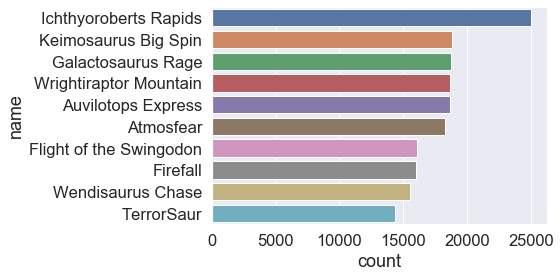

In [376]:
# 作图，显示最畅销的前10
x = tmp_result1['name'][:10]
y = tmp_result1['count'][:10]
sns.barplot(y,x)

由上数据可以发现，游乐园最受欢迎的景点是名为Ichthyoroberts Rapids的景点。其出现(duration不为空)次数为24973,图中也可以清晰的看到最好的前10名。

# 4. 哪种游乐装置的参观时间最长。
确定参与计算的表包括checkins和attractions。并注意以下内容：
1. 确定Ride范围为attractions表中的'Thrill Rides\r','Kiddie Rides\r','Rides for Everyone\r'。
2. 时间选择checkins中duration不为空的目标,且删除掉duration中包含@SD的数据。
3. 注意type为actual
4. 以均值为最终衡量标准。
5. 选择表格与图结合的方式得出结论。

In [312]:
# 转换duration时间为分钟
def transDurationToMin(a_duration):
    if a_duration is None:
        return None
    elif '@'in a_duration:
        return None
    sep_list = a_duration[:].split(':')  # 字符串切分
    mins = 0
    mins += int(sep_list[0]) * 60  # 小时转换为分钟
    mins += int(sep_list[1])  # 分钟
    mins += int(sep_list[2]) / 60  # 秒转分钟
    return mins

# 获取type为actual的attraction和duration
tmp_result2 = copy.deepcopy(df1[['attraction','duration']][df1['type']=='actual'])
# 获取name和category
tmp_result2['name'] = tmp_result2['attraction'].apply(lambda x: df2['Name'][df2['AttractionID'] == x].values[0])
tmp_result2['category'] = tmp_result2['attraction'].apply(lambda x: df2['Category'][df2['AttractionID'] == x].values[0])
# 筛选category中为Ride的游乐装置。
tmp_result2 = tmp_result2[(tmp_result2['category']=='Thrill Rides\r') | (tmp_result2['category']=='Kiddie Rides\r') | (tmp_result2['category']=='Rides for Everyone\r')]
# duration列 dropna
tmp_result2.dropna(axis=0, subset=['duration'], inplace=True)
# 处理 duration时间,转换至min
tmp_result2['duration_min'] = tmp_result2['duration'].apply(lambda x: transDurationToMin(x))
# duration_min列 dropna
tmp_result2.dropna(axis=0, subset=['duration_min'], inplace=True)
# 更新index
tmp_result2.reset_index(drop=True, inplace=True)
tmp_result2

,attraction,duration,name,category,duration_min
0,6,0:06:16,Keimosaurus Big Spin,Thrill Rides\r,6.266667
1,5,1:07:41,Wendisaurus Chase,Thrill Rides\r,67.683333
2,2,0:12:54,Galactosaurus Rage,Thrill Rides\r,12.900000
3,3,0:36:07,Auvilotops Express,Thrill Rides\r,36.116667
4,5,1:05:10,Wendisaurus Chase,Thrill Rides\r,65.166667
...,...,...,...,...,...
280422,13,0:06:38,Cyndisaurus Asteroid,Kiddie Rides\r,6.633333
280423,1,0:04:56,Wrightiraptor Mountain,Thrill Rides\r,4.933333
280424,30,0:37:00,Ichthyoroberts Rapids,Rides for Everyone\r,37.000000
280425,31,0:06:04,Raptor Race,Rides for Everyone\r,6.066667


In [313]:
# 按照名称分组，并获取时间按照均值排序后的结果
tmp_result2.groupby('name').describe()['duration_min'].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
TerrorSaur,14380.0,45.771493,19.891410,0.266667,28.450000,56.133333,61.816667,68.083333
Flight of the Swingodon,16029.0,39.935728,24.799550,0.250000,11.716667,52.083333,63.533333,73.183333
Wendisaurus Chase,15549.0,39.080720,25.059663,0.416667,8.816667,54.916667,61.883333,67.733333
Firefall,15970.0,37.735958,24.821006,0.350000,8.833333,48.366667,62.150000,68.583333
North Line,3546.0,30.213283,6.386698,0.916667,25.666667,30.583333,35.633333,40.416667
Scholtz Express,5200.0,30.207269,6.799882,0.266667,25.433333,30.250000,35.833333,139.500000
Ichthyoroberts Rapids,24907.0,18.058866,10.622158,0.350000,7.733333,16.400000,27.416667,38.800000
Auvilotops Express,18679.0,13.887505,15.480930,0.316667,3.700000,4.816667,21.883333,55.933333
Paleocarrie Carousel,5496.0,10.961918,2.228063,2.250000,9.133333,10.883333,12.900000,17.383333


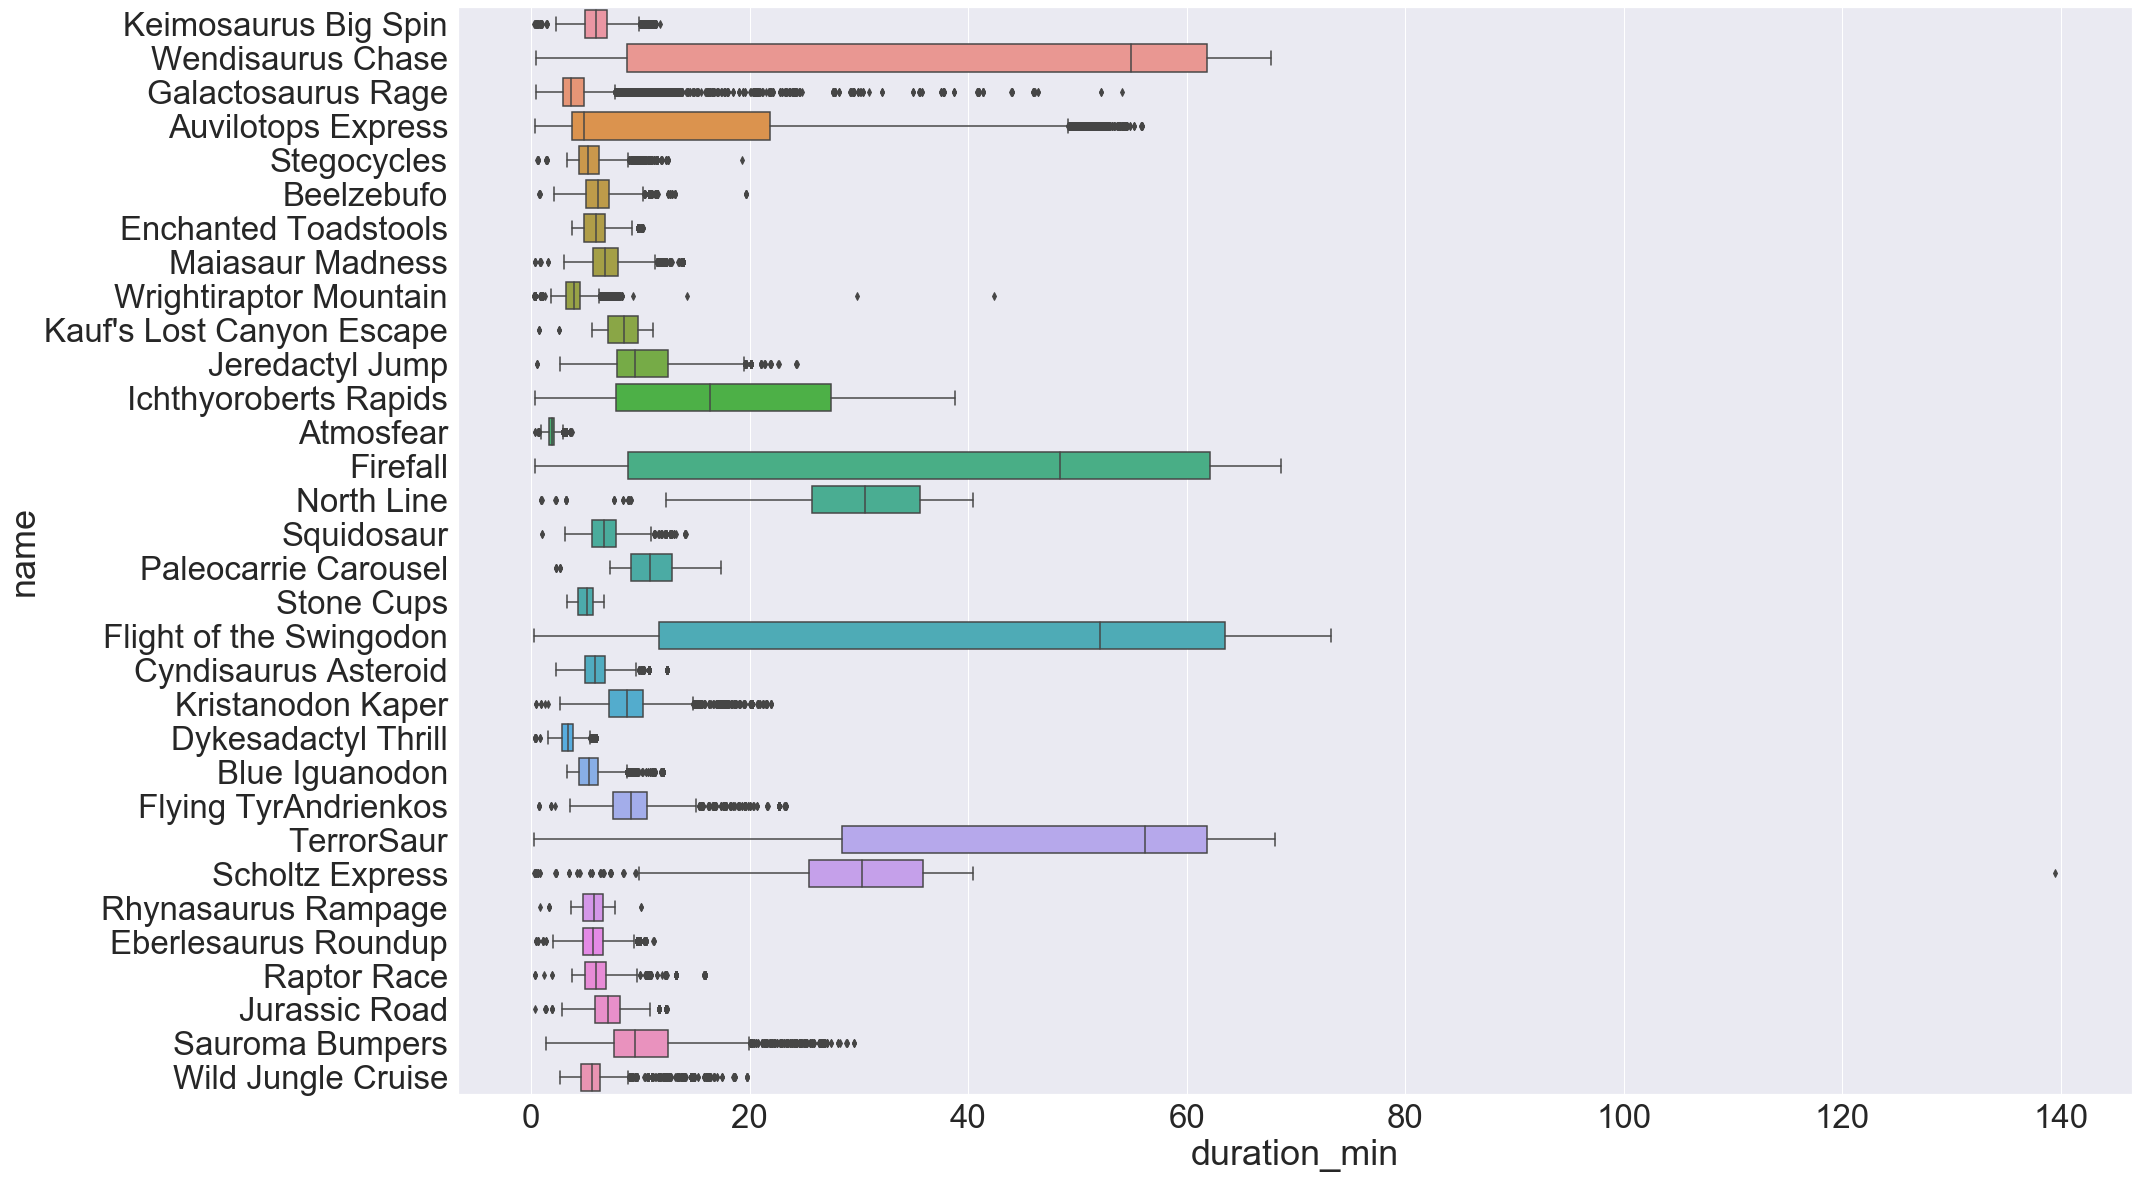

In [314]:
# 画图
plt.figure(figsize=(30,20))  # 设置画布大小
sns.set(font_scale=3)  # 设置字体大小
sns.boxplot(y='name', x='duration_min', data=tmp_result2)

可以看到均值排名前五的各个项目的均值与方差分别为：

项目名称      均值     方差

TerrorSaur     45.77	19.89

Flight of the Swingodon		39.94	24.80	

Wendisaurus Chase		39.08	25.06

Firefall		37.74	24.82

North Line		30.21   6.39	

虽然方差都比较大，但是可以较为清晰的看出均值最大游乐装置为TerrorSaur。同上图中信息一致。

# 4. 哪种快餐的消费者最少
从attractions表中找到type为Fast Food的品类，计算真实消费者最少的排序。其中需要注意的是：
1. checkins表中不区分actual。
2. 以duration不为空为主。
3. 以visitorID数量为准。
4. 选择表格与图结合的方式得出结论。



In [296]:
# 获取type为actual的attraction和duration
tmp_result3= copy.deepcopy(df1[['visitorID', 'attraction', 'duration']])
# 获取name和category的type
tmp_result3['name'] = tmp_result3['attraction'].apply(lambda x: df2['Name'][df2['AttractionID'] == x].values[0])
tmp_result3['cate_type'] = tmp_result3['attraction'].apply(lambda x: df2['type'][df2['AttractionID'] == x].values[0])
# 筛选category中为Ride的游乐装置。
tmp_result3 = tmp_result3[tmp_result3['cate_type']=='Fast Food']
# duration列 dropna
tmp_result3.dropna(axis=0, subset=['duration'], inplace=True)
# 更新index
tmp_result3.reset_index(drop=True, inplace=True)
tmp_result3

,visitorID,attraction,duration,name,cate_type
0,436,36,0:49:18,Paleo Shreckwiches,Fast Food
1,878,39,0:52:50,Chensational Sweets,Fast Food
2,941,36,0:33:06,Paleo Shreckwiches,Fast Food
3,941,39,0:22:07,Chensational Sweets,Fast Food
4,1634,39,0:49:34,Chensational Sweets,Fast Food
...,...,...,...,...,...
8639,2096121,39,0:39:48,Chensational Sweets,Fast Food
8640,2096426,37,1:21:01,Krystal Cook Cafe,Fast Food
8641,2096426,39,0:05:38,Chensational Sweets,Fast Food
8642,2096715,38,0:53:51,Shilobite o'Pizza,Fast Food


In [297]:
# 不同食品下，不同visitorID的量
tmp_result3_2 = tmp_result3.groupby('name')['visitorID'].nunique()
tmp_result3_2

name
Chensational Sweets    2608
Krystal Cook Cafe      1601
Paleo Shreckwiches     1325
Shilobite o'Pizza      1304
Theresaur Food Stop    1008
Name: visitorID, dtype: int64

D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


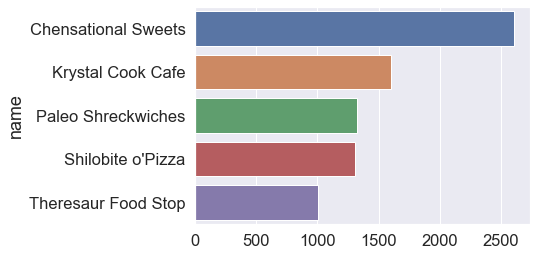

In [302]:
# 作图
sns.set(font_scale=1.5)  # 设置字体大小
x = tmp_result3_2.index
y = tmp_result3_2.values
sns.barplot(y,x)

由数值可以看出，Theresaur Food Stop共有1008人曾经光临，为最少。同图一致。

# 5. 天际线分析
此部分核心关注两个部分：游乐场装置访问次数与访问时间。
1. 个人的理解是访问次数越多，平均时间越少的是越有利的。
2. 类似的，访问次数越少，平均时间越长的是越不利的。
针对这两个特性。基于问题2的数据，进一步对数据进行处理。需要注意的部分包括问题2中的内容，同时强调：
1. 题中的访问时间理解为duration。因为时间戳中的时间并不能很好的反应游乐场的运营属性。、
2. 使用duration的平均值作为参照标准。
3. 对上面两种情况分开探讨。分别找到最有利的点与最不利的点。
4. 选择表格与图结合的方式得出结论

In [349]:
# 获取游乐装置的访问次数
tmp_result4_1 = tmp_result2.groupby('name').count()['duration_min'].reset_index().rename(columns={'duration_min':'count'})
# 获取游乐装置的访问时间
tmp_result4_2 = tmp_result2.groupby('name').mean()['duration_min'].reset_index()
# left merge拼接
tmp_result4 = tmp_result4_1.merge(tmp_result4_2)
tmp_result4

,name,count,duration_min
0,Atmosfear,18262,1.886156
1,Auvilotops Express,18679,13.887505
2,Beelzebufo,3951,6.421045
3,Blue Iguanodon,3916,5.630903
4,Cyndisaurus Asteroid,3742,6.026073
5,Dykesadactyl Thrill,5576,3.384870
6,Eberlesaurus Roundup,5030,5.805706
7,Enchanted Toadstools,3701,5.955503
8,Firefall,15970,37.735958
9,Flight of the Swingodon,16029,39.935728


In [369]:
# 两两比较
def a_dominates_b(a, b, to_min, to_max):

    n_better = 0

    for f in to_min:
        if a[f] > b[f]:
            return False
        n_better += a[f] < b[f]

    for f in to_max:
        if a[f] < b[f]:
            return False
        n_better += a[f] > b[f]

    if n_better > 0:
        return True
    return False

# df内部两两比较
def find_skyline_brute_force(df, to_min, to_max):

    rows = df.to_dict(orient='index')

    skyline = set()

    for i in rows:

        dominated = False

        for j in rows:

            if i == j:
                continue

            if a_dominates_b(rows[j], rows[i], to_min, to_max):
                dominated = True
                break

        if not dominated:
            skyline.add(i)
    
    print(df['name'][skyline])
    return pd.Series(df.index.isin(skyline), index=df.index)

0                  Atmosfear
11        Galactosaurus Rage
12     Ichthyoroberts Rapids
16      Keimosaurus Big Spin
31    Wrightiraptor Mountain
Name: name, dtype: object


Text(0.5, 1.0, 'count vs.duration skyline')

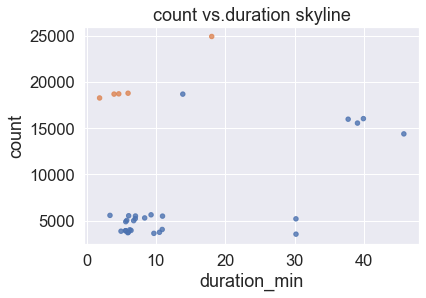

In [371]:
skyline = find_skyline_brute_force(tmp_result4, to_min=['duration_min'], to_max=['count'])
sns.set(font_scale=1.5)  # 设置字体大小
colors = skyline.map({True: 'C1', False: 'C0'})
ax = tmp_result4.plot.scatter(x='duration_min', y='count', c=colors, alpha=0.8)
ax.set_title('count vs.duration skyline')

在这种情况中，天际线目标最小化游乐时间与最大化访问次数。可以从图中看出不同颜色的点代表天际线所经过的点。而列表中打印出来的游乐装置为：Atmosfear、Galactosaurus Rage、Ichthyoroberts Rapids、Keimosaurus Big Spin、Wrightiraptor Mountain。

19    North Line
28    TerrorSaur
Name: name, dtype: object


Text(0.5, 1.0, 'count vs.duration skyline')

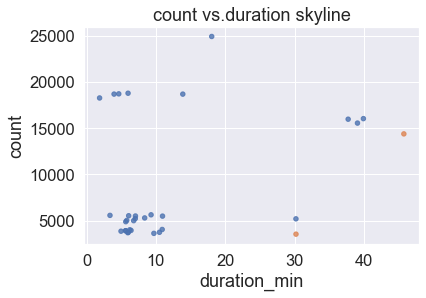

In [372]:
skyline = find_skyline_brute_force(tmp_result4, to_min=['count'], to_max=['duration_min'])
sns.set(font_scale=1.5)  # 设置字体大小
colors = skyline.map({True: 'C1', False: 'C0'})
ax = tmp_result4.plot.scatter(x='duration_min', y='count', c=colors, alpha=0.8)
ax.set_title('count vs.duration skyline')

在这种情况中，天际线目标最大化游乐时间与最小化访问次数。可以从图中看出不同颜色的点代表天际线所经过的点。而列表中打印出来的游乐装置为：North Line、TerrorSaur。